<a href="https://colab.research.google.com/github/omg0809/Agent-Motion-Preditction/blob/main/RESNET_agent_motion_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install l5kit
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/content/drive/MyDrive/PATH_TO_SAMPLE_DATA"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("/content/drive/MyDrive/PATH_TO_SAMPLE_DATA/config_sample.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 16, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 16, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 9300, 'eval_every_n_steps': 10000}}


In [ ]:
def build_model(cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = resnet50(pretrained=True)

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)
    model = model.to(device)
    return model

In [ ]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

In [ ]:
# ==== INIT MODEL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = build_model(cfg)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")

Using device: cuda


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
dataset = AgentDataset(cfg, train_zarr, rasterizer)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# Randomly split the dataset
tr_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(tr_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
test_dataloader = DataLoader(test_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Training



In [ ]:
# ==== TRAIN LOOP
num_batches = len(train_dataloader)
print(num_batches)
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(num_batches))
losses_train = []
avg_loss = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    #model.train()
    #torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    avg_loss.append(np.mean(losses_train))
    progress_bar.set_description(f"batch_loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

6280


batch_loss: 1.6667643785476685 loss(avg): 12.291183389870413: 100%|██████████| 6280/6280 [54:30<00:00,  1.92it/s]


In [ ]:
SAVE_PATH = "/content/drive/MyDrive/MODEL_RESNET50/trained_resnet_50.pth"
torch.save(model.state_dict(),SAVE_PATH)

### Plot Loss Curve
We can plot the train loss against the iterations (batch-wise)

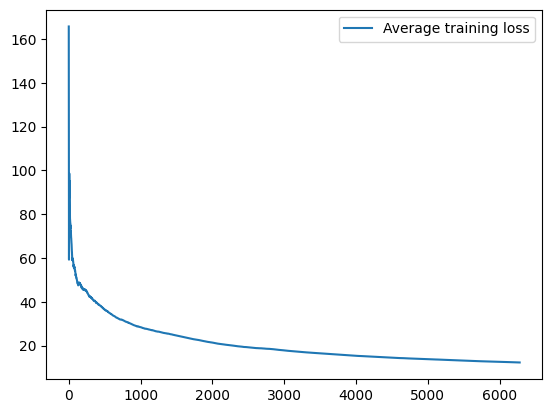

In [ ]:
plt.plot(np.arange(len(avg_loss)), avg_loss, label="Average training loss")
plt.legend()
plt.show()

## Testing

In [ ]:
# load trained model
SAVE_PATH = "/content/drive/MyDrive/MODEL_RESNET50/trained_resnet_50.pth"
model = build_model(cfg)
model.load_state_dict(torch.load(SAVE_PATH))
model = model.to(device)

In [ ]:
# Evaluate the model on the test set
tr_it = iter(test_dataloader)
progress_bar = tqdm(range(len(test_dataloader)))
model.eval()
torch.set_grad_enabled(False)
losses_test = []
avgTest_loss = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    loss, _ = forward(data, model, device, criterion)
    losses_test.append(loss.item())
    avgTest_loss.append(np.mean(losses_test))
    progress_bar.set_description(f"Batch loss: {loss.item()} loss(avg): {np.mean(losses_test)}")

## Plot Testing Loss

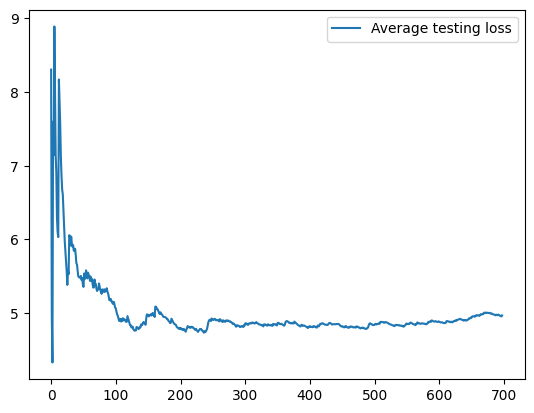

In [ ]:
plt.plot(np.arange(len(avgTest_loss)), avgTest_loss, label="Average testing loss")
plt.legend()
plt.show()

## Visualising Results

(50, 2)


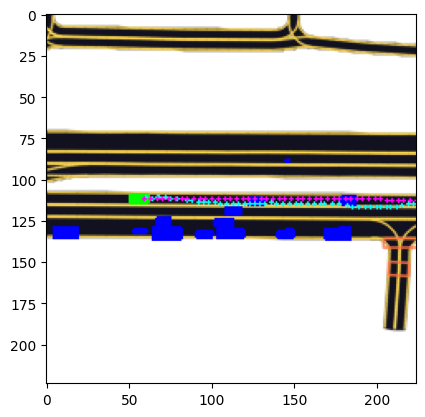

In [ ]:
sample_idx = np.random.randint(0,100)
sample_data = test_dataset[sample_idx]
img = sample_data["image"].transpose(1,2,0)
img = dataset.rasterizer.to_rgb(img)

target_positions = sample_data["target_positions"]
out_net = model(torch.from_numpy(sample_data["image"]).unsqueeze(0).to(device))
out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
print(out_pos.shape)

predicted_positions = []
target_positions = []
# store absolute world coordinates
predicted_positions.append(transform_points(out_pos, sample_data["world_from_agent"]))
# retrieve target positions from the GT and store as absolute coordinates
#target_positions.append(sample_data['target_positions'] + sample_data["centroid"][:2])
target_positions.append(transform_points(sample_data['target_positions'], sample_data["world_from_agent"]))

predicted_positions = transform_points(np.concatenate(predicted_positions), sample_data["raster_from_world"])
target_positions = transform_points(np.concatenate(target_positions), sample_data["raster_from_world"])

draw_trajectory(img, predicted_positions, PREDICTED_POINTS_COLOR)
draw_trajectory(img, target_positions, TARGET_POINTS_COLOR)

plt.imshow(img)
plt.show()